# Performing pyscenic on atlas to idenitify regulons

#### problems with pyscenic package and dependencies, therefore for all bash commands in this notebook, instead of running in my normal environment (env) run in environment called pyscenic2 (mamba activate pyscenic2) as this environmemnt has the correct package versions needed

* pyscenic installed on environemnt: https://pyscenic.readthedocs.io/en/latest/installation.html#docker-podman-and-singularity-apptainer-images 
* pyscenic pipline based on: https://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.html
* GRN inference run using arboreto method: https://pyscenic.readthedocs.io/en/latest/faq.html#i-am-having-problems-with-dask

# Making environment for running bash commands


``` bash 
conda create -y -n pyscenic2 python=3.10
conda activate pyscenic2

# Install pySCENIC locally
mkdir /scratch/user/s4436039/software/
cd /scratch/user/s4436039/software/
git clone https://github.com/aertslab/pySCENIC.git
cd pySCENIC/
pip install -e . # this will install pySCENIC in editable mode

# Fix the dependencies
# also install loompy from the github becaues they fixed the issue with normalize.py 
# https://github.com/linnarsson-lab/loompy/issues/186
pip install git+https://www.github.com/linnarsson-lab/loompy.git
# use numpy==1.24.0 because of https://github.com/aertslab/pySCENIC/issues/584
pip install numpy==1.24.0

cd /scratch/user/s4436039/scdata/PySCENIC

#running pyscenic (step that was giving error in normal environment)
pyscenic aucell \
    DC1mreg_loom.loom \
    reg.csv \
    --output pyscenic_output.loom \
    --num_workers 1
```

# Load packages

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
#import pyscenic
#from pyscenic.aucell import aucell
import numpy as np

sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


# Import h5ad

In [2]:
#set current directory 
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')
os.getcwd()

'/scratch/user/s4436039/scdata/Python_Integration_Sep'

In [3]:
# read in data
data = sc.read_h5ad('NRclean_clustered2.h5ad')

In [4]:
#subset out DCs
data_DC = data[data.obs["NR_annotations_simple"].isin(["cDC1","cDC2","mregDC"])]

In [7]:
data_DC

View of AnnData object with n_obs × n_vars = 30241 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_a

In [8]:
os.chdir('/scratch/user/s4436039/scdata/PySCENIC_Jan')
os.getcwd()

'/scratch/user/s4436039/scdata/PySCENIC_Jan'

## make loom file with expression data:

In [9]:
import loompy as lp
import numpy as np

In [10]:
# Save the path where you want loom file to save (current directory)
f_loom_path_DC = "DC_loom.loom"

In [11]:
row_attrs = { 
    "Gene": np.array(data_DC.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(data_DC.obs.index) ,
    "nGene": np.array( np.sum(data_DC.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(data_DC.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_DC, data_DC.X.transpose(), row_attrs, col_attrs )

## 1. GRN Inference - Run GRN pyscenic 
* TF list (allTFs_hg38.txt) downloaded from https://resources.aertslab.org/cistarget/tf_lists/ 

### Run in bash (in pyscenic2 environment): 
``` bash
cd /scratch/user/s4436039/scdata/PySCENIC_Jan
arboreto_with_multiprocessing.py DC_loom.loom allTFs_hg38.txt --output adj.tsv --num_workers 20
```
* can use 20 workers as i requested bunya job with 20 cpus (~5min)

In [12]:
# read in the adjacencies matrix
adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')

In [13]:
adjacencies.head()

,TF,target,importance
0,PSMA6,GABARAP,28.059309
1,IRF8,CLEC9A,27.532223
2,IRF8,CLNK,24.721919
3,IRF8,RGCC,22.454228
4,NR4A1,DUSP2,20.902900


# 2. Cis-Regulatory Analysis - Regulon prediction 
* output: the regulons in reg.csv - list of adjacencies between a TF and its targets stored in MOTIFS_FNAME
* ranking database downloaded from: https://resources.aertslab.org/cistarget/databases/ details --> used Homo sapiens - hg38 - refseq_r80 - SCENIC+ databases - Gene based - hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
* motif-to-TF database downloaded from: https://resources.aertslab.org/cistarget/motif2tf/ (this database links TF binding motifs to their corresponding TFs)

### ctx step: cis-regulatory motif analysis 

### Run in bash (in pyscenic2 environment):

``` bash
pyscenic ctx adj.tsv \
    hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
    --annotations_fname motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
    --expression_mtx_fname DC_loom.loom \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20
```

# Regulon Activity/Cellular enrichment (aucell)
* identifies the activity of these regulons at the single cell level by calculating an enrichment score

### First checking most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC (as done in tutorial)

In [14]:
nGenesDetectedPerCellbefore = np.sum(data_DC.X>0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCellbefore)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

0.01     27.0
0.05     47.0
0.10     70.0
0.50    171.0
1.00    503.0
dtype: float64


In [15]:
import seaborn as sns

/scratch/temp/12142480/ipykernel_2362699/3887338572.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')


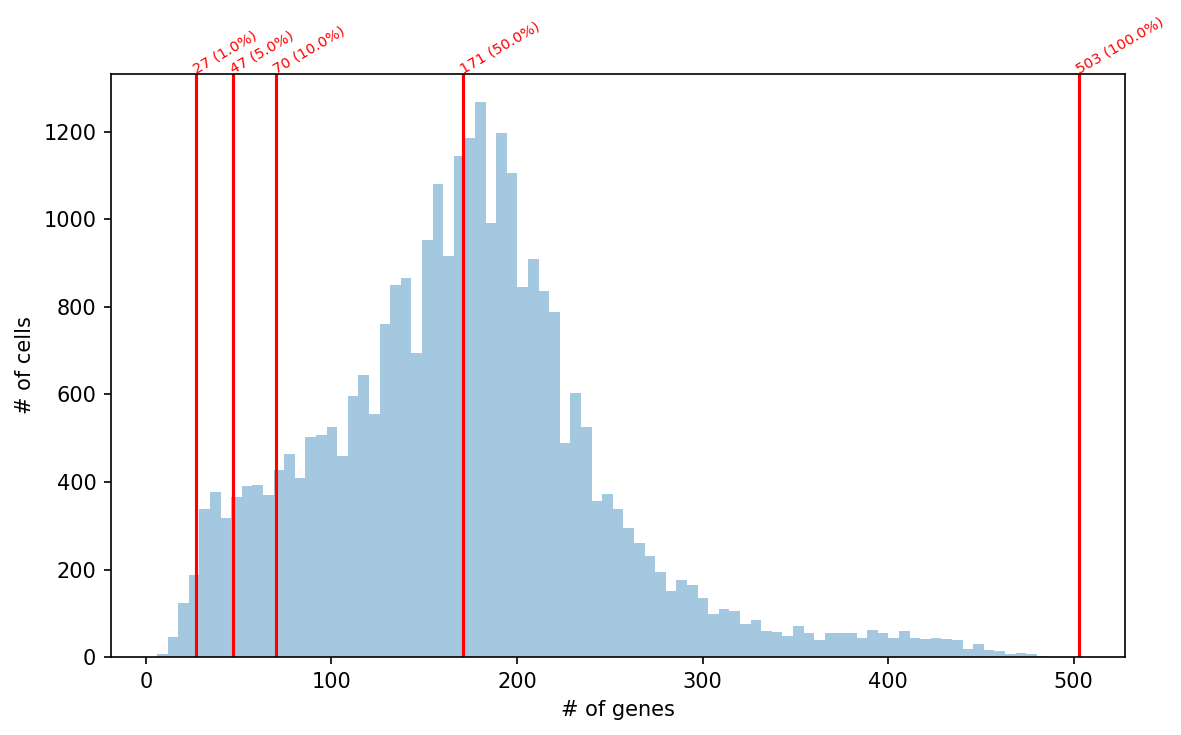

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small', rotation_mode='anchor')
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

* default auc_threshold is 0.05 (5%) which here would include 47 genes 

## Run AUC (area under the curve for enrichment algorithm to calculate regulon activity scores):

### Run in bash (in pyscenic2 environment):

``` bash
pyscenic aucell \
    DC_loom.loom \
    reg.csv \
    --output pyscenic_output.loom \
    --num_workers 20

## Output SCENIC's AUC matrix:

In [17]:
import json
import zlib
import base64

In [18]:
# collect SCENIC AUCell output
lf = lp.connect("pyscenic_output.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [35]:
# activity score for each regulon (column) for every cell (row)
auc_mtx.head()

,AHR(+),ATF3(+),BACH2(+),BATF(+),BHLHE40(+),BHLHE41(+),CREM(+),DDIT3(+),ELF3(+),ETS1(+),...,MAF(+),MAFF(+),NFE2(+),NFKB1(+),NFKB2(+),NR1H3(+),PRDM1(+),REL(+),SOX4(+),TCF7L2(+)
GSE215120_AM1_AAATGCCCAGAGCCAA-1,0.014815,0.032522,0.017493,0.008354,0.033690,0.084034,0.030231,0.121693,0.031746,0.022378,...,0.022011,0.046005,0.000000,0.021613,0.053894,0.062434,0.000000,0.031684,0.004141,0.011905
GSE215120_AM1_ACACTGATCCACTGGG-1,0.001411,0.038906,0.011986,0.044277,0.062196,0.000000,0.041956,0.000000,0.000000,0.041634,...,0.012275,0.052569,0.000000,0.029549,0.078627,0.004233,0.017094,0.041892,0.025190,0.000000
GSE215120_AM1_ACAGCCGCAAACCTAC-1,0.043563,0.041494,0.022190,0.000000,0.046647,0.000000,0.047858,0.243386,0.052910,0.006245,...,0.026878,0.028302,0.009009,0.026998,0.021041,0.005291,0.000000,0.028260,0.049517,0.000000
GSE215120_AM1_ACCAGTAAGACTGGGT-1,0.039330,0.021653,0.034338,0.000000,0.047295,0.056956,0.026721,0.000000,0.000000,0.004424,...,0.014392,0.032015,0.016731,0.026006,0.015873,0.023280,0.000000,0.028820,0.056418,0.000000
GSE215120_AM1_ACGTCAACAAGGACTG-1,0.003880,0.004227,0.000000,0.000000,0.025267,0.000000,0.010848,0.161376,0.137566,0.020557,...,0.008254,0.015496,0.000000,0.019629,0.001107,0.000000,0.000000,0.019048,0.043306,0.000000


# Plot regulon specificity score 
* see Fig 3B,D from this paper as an example: https://insight.jci.org/articles/view/159751/sd/1
* https://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/SCENIC%20Protocol%20-%20Case%20study%20-%20Cancer%20data%20sets.html

In [36]:
from pyscenic.rss import regulon_specificity_scores

In [38]:
data_DC

View of AnnData object with n_obs × n_vars = 30241 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_a

In [42]:
rss = regulon_specificity_scores(auc_mtx, data_DC.obs["NR_annotations_simple"])

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

* switch to environemnt pyscenic (ive downloaded numpy 1.20.0 instead of 1.24.0)

ugh ok sorry I tried running 
rss = regulon_specificity_scores(auc_mtx, data_DC.obs["NR_annotations_simple"])
but i get another deprecation error
AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
I just tried downgrading to numpy 1.20.0 in my old pyscenic environment but it wont let me. I'll check that I'm not missing something in the tutorial though

# add activity scores to my processed sc object